# 순환 신경망 RNN

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

# tf.config.experimental.set_memory_growth(physical_devices[2], enable=True)


In [2]:
# 넘파이로 구현한 간단한 RNN
import numpy as np

timesteps = 100 # 입력 시퀀스에 있는 타임스텝의 수
input_features = 32 # 입력 특성의 차원
output_features = 64 # 출력 특성의 차원

inputs = np.random.random((timesteps, input_features)) # 입력 데이터: 예제를 위해 생성한 난수

state_t = np.zeros((output_features,)) # 초기 상태: 모두 0인 벡터

# 랜덤한 가중치 행렬 만들기
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = [] 
for input_t in inputs: # input_t의 크기는 (input_features,)
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) 
    successive_outputs.append(output_t) # 이 출력을 리스트에 저장
    state_t = output_t # 다음 타임스텝을 위해 네트워크의 상태를 업데이트
    
final_output_sequence = np.stack(successive_outputs, axis=0) # 최종 출력은 크기가 (timesteps, output_features)인 2D 텐서


In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 전체 상태 시퀀스를 반환하고 싶은 경우
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [5]:
# 여러 개의 순환 층을 쌓는 경우
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32)) # 맨 위 층만 마지막 출력을 반환
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


In [6]:
# IMDB 데이터 전처리하기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000 # 특성으로 사용할 단어의 수
maxlen = 500 # 사용할 텍스트의 길이(가장 빈번한 max_features개의 단어만 사용)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기: ', input_train.shape)
print('input_test 크기: ', input_test.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기:  (25000, 500)
input_test 크기:  (25000, 500)


In [7]:
# Embedding 층과 SimpleRNN 층을 사용한 모델 훈련하기
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 54s 345ms/step - loss: 0.6171 - acc: 0.6577 - val_loss: 0.4742 - val_acc: 0.8068
Epoch 2/10
157/157 [==============================] - 54s 345ms/step - loss: 0.3968 - acc: 0.8384 - val_loss: 0.3753 - val_acc: 0.8456
Epoch 3/10
157/157 [==============================] - 54s 344ms/step - loss: 0.2995 - acc: 0.8795 - val_loss: 0.4450 - val_acc: 0.7836
Epoch 4/10
157/157 [==============================] - 53s 339ms/step - loss: 0.2390 - acc: 0.9069 - val_loss: 0.3700 - val_acc: 0.8534
Epoch 5/10
157/157 [==============================] - 53s 338ms/step - loss: 0.1874 - acc: 0.9299 - val_loss: 0.4332 - val_acc: 0.8192
Epoch 6/10
157/157 [==============================] - 54s 342ms/step - loss: 0.1315 - acc: 0.9531 - val_loss: 0.3886 - val_acc: 0.8514
Epoch 7/10
157/157 [==============================] - 54s 342ms/step - loss: 0.0879 - acc: 0.9716 - val_loss: 0.5805 - val_acc: 0.8188
Epoch 8/10
157/157 [==============================] - 5

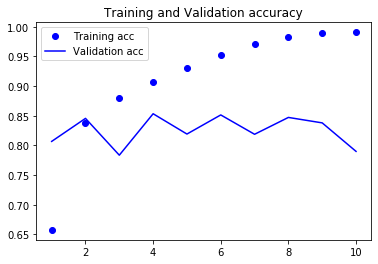

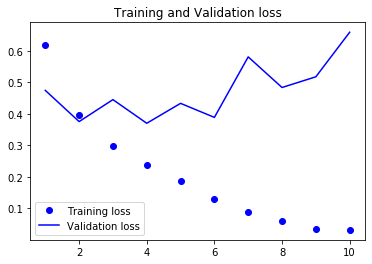

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()



In [9]:
# 케라스에서 LSTM 층 사용하기
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
313/313 [==============================] - 11s 35ms/step - loss: 0.4706 - acc: 0.7786 - val_loss: 0.4263 - val_acc: 0.8286
Epoch 2/10
313/313 [==============================] - 11s 34ms/step - loss: 0.2833 - acc: 0.8917 - val_loss: 0.3115 - val_acc: 0.8674
Epoch 3/10
313/313 [==============================] - 11s 35ms/step - loss: 0.2287 - acc: 0.9147 - val_loss: 0.8815 - val_acc: 0.7338
Epoch 4/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2006 - acc: 0.9274 - val_loss: 0.2867 - val_acc: 0.8834
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1744 - acc: 0.9369 - val_loss: 0.3621 - val_acc: 0.8798
Epoch 6/10
313/313 [==============================] - 11s 34ms/step - loss: 0.1581 - acc: 0.9443 - val_loss: 0.3946 - val_acc: 0.8468
Epoch 7/10
313/313 [==============================] - 11s 34ms/step - loss: 0.1441 - acc: 0.9485 - val_loss: 0.3477 - val_acc: 0.8744
Epoch 8/10
313/313 [==============================] - 11s 34ms